In [400]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import operator
from sklearn.model_selection import StratifiedKFold

In [424]:
data = arff.loadarff('./Data/kc2.arff.txt')
df = pd.DataFrame(data[0])
df['problems'] = df['problems'].apply(lambda x: str(x)[1:])
#df['problems'] = df['problems'].map({"'true'": True, "'false'": False})

distances = []
radius = []

qtd_k = [1,2,3,5,7,9,11,13,15]
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [425]:
df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,lOCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,problems
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2.0,2.0,2.0,2.0,1.2,1.2,1.2,1.2,1.4,'no'
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,'yes'
2,415.0,59.0,50.0,51.0,1159.0,8411.31,0.01,103.53,81.24,870848.58,...,359.0,35.0,9.0,10.0,47.0,106.0,692.0,467.0,106.0,'yes'
3,230.0,33.0,10.0,16.0,575.0,3732.82,0.03,39.82,93.74,148644.06,...,174.0,15.0,34.0,5.0,23.0,67.0,343.0,232.0,65.0,'yes'
4,175.0,26.0,12.0,13.0,500.0,3123.96,0.03,29.48,105.96,92103.07,...,142.0,7.0,19.0,4.0,18.0,58.0,310.0,190.0,51.0,'yes'


In [403]:
def euclidian_dist(x1, x2):
    distance = 0
    for x in range(np.array(x1).size - 1):
        distance += np.square(x1[x] - x2[x])
    return np.sqrt(distance)

In [404]:
def calc_dists(trainingSet, testInstance):
    d = []
    for t in range(len(trainingSet)):
        dist = euclidian_dist(df.iloc[trainingSet[t]], df.iloc[testInstance])
        d.append((df.iloc[trainingSet[t]], dist))
    return d

In [405]:
def knn(fold, i, k):
    neighbors = []
    classQtd = {}
    d = distances[fold][i]
    d.sort(key=lambda x: x[1])
    for x in range(k):
        neighbors.append(d[x][0])
    for x in range(len(neighbors)):
        class_label = neighbors[x][-1]
        if class_label in classQtd:
            classQtd[class_label] += 1
        else:
            classQtd[class_label] = 1
    sortedVotes = sorted(classQtd.items(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

In [406]:
def weight_knn(fold, i, k):
    weight_dists = []
    neighbors = []
    classQtd = {}
    d = distances[fold][i]
    d.sort(key=lambda x: x[1])
    for x in range(k):
        neighbors.append(d[x][0])
        if(d[x][1] == 0):
            return neighbors[x][-1]
        weight_dists.append(d[x][1])
    weight_dists = [(1 / math.pow(d, 2)) for d in weight_dists]
    for x in range(len(neighbors)):
        class_label = neighbors[x][-1]
        acc = weight_dists[x]
        if class_label in classQtd:
            classQtd[class_label] += acc
        else:
            classQtd[class_label] = acc
    sortedVotes = sorted(classQtd.items(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

In [407]:
def adaptive_rule(trainingSet):
    radius = []
    qtd = range(len(trainingSet))
    for i in qtd:
        aux = []
        for j in qtd:
            if(df.iloc[trainingSet[i]][-1] != df.iloc[trainingSet[j]][-1]):
                dist = euclidian_dist(df.iloc[trainingSet[i]], df.iloc[trainingSet[j]]) - 0.00000000001
                if(dist >= 0):
                    aux.append(dist)
        radius.append(min(aux))
    return radius

In [408]:
def adaptive_knn(fold, t, k):
    neighbors = []
    dists = []
    classQtd = {}
    d = distances[fold][t]
    for i in range(len(d)):
        aux = d[i][1] / radius[fold][i]
        dists.append((d[i][0], aux))
    dists.sort(key=lambda x: x[1])
    for x in range(k):
        neighbors.append(dists[x][0])
    for x in range(len(neighbors)):
        class_label = neighbors[x][-1]
        if class_label in classQtd:
            classQtd[class_label] += 1
        else:
            classQtd[class_label] = 1
    sortedVotes = sorted(classQtd.items(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

In [409]:
def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet.iloc[x][-1] == predictions[x]:
            correct += 1
    return correct / float(len(testSet))

In [410]:
import time
def calc_knn(knn_type):
    accuracy = []
    for k in qtd_k:
        acc = 0
        cont = 0
        start = time.time()
        for train_index, test_index in skf.split(df.iloc[:, :-1], df.iloc[:, -1]):
            predictions = []
            for i in range(len(test_index)):
                result = knn_type(cont, i, k)
                predictions.append(result)
            acc += getAccuracy(df.iloc[test_index], predictions)
            cont += 1
        accuracy.append(acc / 5)
        delay = time.time() - start
        print('K: %d' % k)
        print(' - Accuracy: %f' % (acc / 5))
        print(' - Time: %fs' % delay)
    return accuracy

In [426]:
#Necessário executar este bloco primeiro, para ser feito os cálculos das distâncias e raios. Foi feito dessa forma
    #para evitar a execução deste bloco para cada k.
begin = time.time()
for train_index, test_index in skf.split(df.iloc[:, :-1], df.iloc[:, -1]):
    d = []
    for i in range(len(test_index)):
        d.append(calc_dists(train_index, test_index[i]))
    distances.append(d)
    radius.append(adaptive_rule(train_index))
end = time.time()

In [427]:
timer = end - begin
print('Time: %f min' % (timer / 60))

Time: 12.331034 min


K: 1
 - Accuracy: 0.739432
 - Time: 0.193504s
K: 2
 - Accuracy: 0.739432
 - Time: 0.179860s
K: 3
 - Accuracy: 0.781538
 - Time: 0.158135s
K: 5
 - Accuracy: 0.806227
 - Time: 0.154270s
K: 7
 - Accuracy: 0.815861
 - Time: 0.211977s
K: 9
 - Accuracy: 0.821575
 - Time: 0.256214s
K: 11
 - Accuracy: 0.821612
 - Time: 0.222378s
K: 13
 - Accuracy: 0.806245
 - Time: 0.191583s
K: 15
 - Accuracy: 0.806264
 - Time: 0.257909s


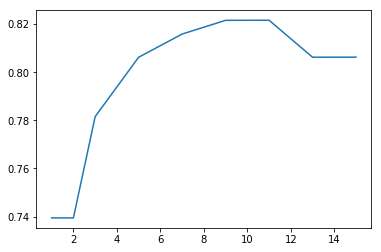

In [428]:
accuracy = calc_knn(lambda train, test, k: knn(train, test, k))
plt.plot(qtd_k, accuracy)

K: 1
 - Accuracy: 0.739432
 - Time: 0.160957s
K: 2
 - Accuracy: 0.739432
 - Time: 0.132934s
K: 3
 - Accuracy: 0.750879
 - Time: 0.154098s
K: 5
 - Accuracy: 0.756630
 - Time: 0.156787s
K: 7
 - Accuracy: 0.758535
 - Time: 0.202786s
K: 9
 - Accuracy: 0.762344
 - Time: 0.245975s
K: 11
 - Accuracy: 0.764267
 - Time: 0.225399s
K: 13
 - Accuracy: 0.762344
 - Time: 0.205394s
K: 15
 - Accuracy: 0.764249
 - Time: 0.240888s


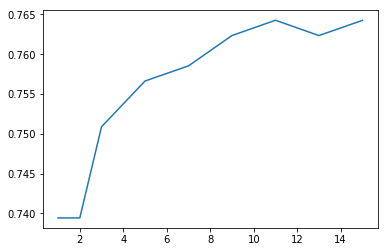

In [429]:
accuracy_w = calc_knn(lambda train, test, k: weight_knn(train, test, k))
plt.plot(qtd_k, accuracy_w)

K: 1
 - Accuracy: 0.735623
 - Time: 0.274353s
K: 2
 - Accuracy: 0.735623
 - Time: 0.252986s
K: 3
 - Accuracy: 0.760586
 - Time: 0.333337s
K: 5
 - Accuracy: 0.777766
 - Time: 0.299307s
K: 7
 - Accuracy: 0.772015
 - Time: 0.287083s
K: 9
 - Accuracy: 0.783498
 - Time: 0.294076s
K: 11
 - Accuracy: 0.785421
 - Time: 0.386368s
K: 13
 - Accuracy: 0.793114
 - Time: 0.330806s
K: 15
 - Accuracy: 0.793114
 - Time: 0.400568s


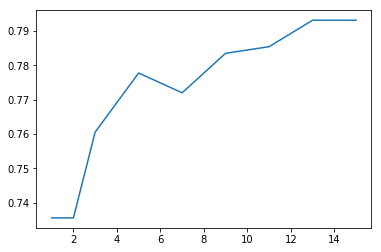

In [430]:
accuracy_adap = calc_knn(lambda fold, i, k: adaptive_knn(fold, i, k))
plt.plot(qtd_k, accuracy_adap)

In [431]:
print(np.mean(accuracy))
print(np.mean(accuracy_w))
print(np.mean(accuracy_adap))

0.7931318681318681
0.7553459503459503
0.7707509157509158


In [433]:
print(np.std(accuracy))
print(np.std(accuracy_w))
print(np.std(accuracy_adap))

0.03082987100635507
0.009399026956833199
0.021081835156471895
